In [1]:
%load_ext autoreload
%autoreload 2

import os
import tensorflow as tf

# --- CRITICAL: Configure TF before importing anything else ---
# Disable GPU visibility to force CPU mode
try:
    # Check if we can still configure
    tf.config.set_visible_devices([], 'GPU')
    print("🚀 FORCE CPU MODE ACTIVE: GPU is now invisible to TensorFlow.")
except RuntimeError as e:
    print("⚠️ Could not disable GPU: TensorFlow was already initialized. Restart the Kernel!")
# -------------------------------------------------------------

import numpy as np

# Ensure we can import from the local folder
try:
    # Now it is safe to import these, which use TF internally
    from aesindy.solvers import SynthData
    from aesindy.training import TrainModel
except ImportError:
    raise ImportError("Run this script from the root directory of the project.")

🚀 FORCE CPU MODE ACTIVE: GPU is now invisible to TensorFlow.


In [3]:
CASE_NAME = 'lorenz' 

# ==========================================
# 2. EXPERIMENT CONFIGURATIONS
# derived from aesindy/dynamical_models.py & testcases/
# ==========================================
configs = {
    'lorenz': {
        'model': 'lorenz',
        'system_coefficients': [10, 28, 8/3],  # sigma, rho, beta
        'normalization': [1/40, 1/40, 1/40],   # Scale to approx [-1, 1]
        'latent_dim': 3,                       # 3D chaotic attractor
        'poly_order': 2,                       # Quadratic terms (xy, xz)
        'include_sine': False,
        'input_dim': 128,                      # Time-delay window size
        'dt': 0.01,                            # Time step
        'tend': 20,                            # Simulation duration
        'n_ics': 100,                          # Number of training trajectories
    },
    'rossler': {
        'model': 'rossler',
        'system_coefficients': [0.2, 0.2, 5.7], # a, b, c
        'normalization': [1/40, 1/40, 1/40],
        'latent_dim': 3,
        'poly_order': 2,
        'include_sine': False,
        'input_dim': 128,
        'dt': 0.04,                            # Rossler is slower, bigger dt
        'tend': 50,
        'n_ics': 100,
    },
    'predator_prey': {
        'model': 'predator_prey',
        'system_coefficients': [1.0, 0.1, 1.5, 0.75], # alpha, beta, gamma, delta
        'normalization': [1/10, 1/10],
        'latent_dim': 2,                       # 2D limit cycle
        'poly_order': 2,
        'include_sine': False,
        'input_dim': 128,
        'dt': 0.01,
        'tend': 20,
        'n_ics': 100,
    },
    'pendulum': {
        'model': 'pendulum',
        'system_coefficients': [9.8, 1],       # g, L
        'normalization': [1/5, 1/5],
        'latent_dim': 2,
        'poly_order': 1,                       # Linear terms...
        'include_sine': True,                  # ...plus Sine terms (sin(x))
        'input_dim': 128,
        'dt': 0.01,
        'tend': 10,
        'n_ics': 100,
    }
}

In [4]:
# ==========================================
# 3. GLOBAL HYPERPARAMETERS
# Used across all experiments (from testcases/default_params.py)
# ==========================================
selected_config = configs[CASE_NAME]
params = {}
params.update(selected_config)

In [5]:
from testcases.default_params import params as default_params

In [7]:
params = default_params.copy()
# params['model'] = 'lorenz'

In [ ]:
### Parameters for the methods 

# Training & Network
params['case'] = CASE_NAME
params['widths_ratios'] = [0.5, 0.25]   # Encoder: 128 -> 64 -> 32 -> latent
params['activation'] = 'elu'
params['use_bias'] = True
params['batch_size'] = 32
params['max_epochs'] = 1000             # Paper often used 500-2000
params['learning_rate'] = 1e-3
params['learning_rate_sched'] = False
params['print_progress'] = True
params['print_frequency'] = 50          # Print equations every 50 epochs

# SINDy (Equation Discovery)
params['coefficient_threshold'] = 0.05  # Threshold for sparsity
params['threshold_frequency'] = 50      # Pruning frequency
params['coefficient_initialization'] = 'constant'
params['fix_coefs'] = False             # Learn coefficients
params['exact_features'] = False        # Discover structure automatically
params['sindy_pert'] = 0.0
params['ode_net'] = False               # Use SINDy, not NeuralODE

# Loss Function Weights (Critical for convergence)
params['loss_weight_rec'] = 1.0         # Reconstruction
params['loss_weight_sindy_z'] = 0.05    # Derivatives in Latent space
params['loss_weight_sindy_x'] = 1e-4    # Derivatives in Input space
params['loss_weight_sindy_regularization'] = 1e-5 # Sparsity (L1)
params['loss_weight_integral'] = 0.0    # Optional integral loss
params['loss_weight_x0'] = 0.0
params['loss_weight_layer_l2'] = 0.0
params['loss_weight_layer_l1'] = 0.0

# Misc
params['noise'] = 0.0
params['data_path'] = 'results'
params['save_checkpoints'] = False
params['train_ratio'] = 0.8
params['svd_dim'] = None
params['scale'] = False
params['sparse_weighting'] = None
params['trainable_auto'] = True
params['use_sindycall'] = False
params['ode_net_widths'] = [] # Unused

params['fixed_coefficient_mask'] = False  # Important: Set to False to strictly "discover" equations. Otherwise, the problem is just a Parameter Tuning Optimization problem 

In [8]:
print(f"--- Running Experiment: {CASE_NAME.upper()} ---")
print(f"System: {params['model']}")
print(f"Coefficients: {params['system_coefficients']}")

# 1. Generate Data
print("\nGenerating Synthetic Data...")
S = SynthData(model=params['model'],
            args=params['system_coefficients'],
            noise=params['noise'],
            input_dim=params['input_dim'],
            normalization=params['normalization'])

# Run simulation to create the Hankel matrix (time-delay embeddings)
S.run_sim(params['n_ics'], params['tend'], params['dt'])

--- Running Experiment: LORENZ ---
System: predator_prey
Coefficients: None

Generating Synthetic Data...
generating solutions..


100%|██████████| 5/5 [00:00<00:00, 23.11it/s]


In [13]:
params['max_epochs'] = 200
params['latent_dim'] = 3

# to make the optimization goes faster

params['coefficient_threshold'] = 0.05  

# 2. Cut more often!
# Check for terms to delete every 20 epochs instead of 100.
params['threshold_frequency'] = 20      

# 3. Make Physics Matter!
# Increase the penalty for wrong equations by 100x-500x.
# params['loss_weight_sindy_z'] = 0.05    

# # 4. Push harder on Sparsity!
# # Increase the L1 penalty so terms shrink faster between cuts.
# params['loss_weight_sindy_regularization'] = 1e-3

# coefficient_initialization# 1. Switch initialization mode to 'true' (uses ground truth values)
params['coefficient_initialization'] = 'true' #so the values of the parameters are close to the groundtruth


# trainer.fit()


In [15]:
params['coefficient_initialization'] = 'true'
params['sindy_pert'] = 0.01

In [16]:
# 2. Train Model
print("\nStarting Training...")
trainer = TrainModel(S, params)


Starting Training...


In [17]:
trainer.model.sindy.coefficients.numpy(), trainer.data.sindy_coefficients

(array([[-0.00350047, -0.00276143],
        [ 1.0039262 , -0.00308103],
        [ 0.00233948, -1.5032616 ],
        [ 0.00190394, -0.0049809 ],
        [-0.10103248,  0.07291022],
        [-0.00204861, -0.00213399]], dtype=float32),
 array([[ 0.   ,  0.   ],
        [ 1.   ,  0.   ],
        [ 0.   , -1.5  ],
        [ 0.   ,  0.   ],
        [-0.1  ,  0.075],
        [ 0.   ,  0.   ]], dtype=float32))

In [18]:
trainer.fit()

results_202511291555_predator_prey_rando
{'data_path': 'results/', 'case': 'rando', 'model': 'predator_prey', 'tend': 20, 'dt': 0.001, 'tau': None, 'system_coefficients': None, 'normalization': None, 'latent_dim': 2, 'noise': 0.0, 'interpolate': False, 'interp_dt': 0.01, 'interp_kind': 'cubic', 'interp_coefs': [21, 3], 'n_ics': 5, 'train_ratio': 0.8, 'input_dim': 128, 'poly_order': 2, 'include_sine': False, 'exact_features': False, 'svd_dim': None, 'scale': False, 'ode_net': False, 'ode_net_widths': [1.5, 3], 'coefficient_threshold': 1e-06, 'threshold_frequency': 100, 'coefficient_initialization': 'true', 'fixed_coefficient_mask': False, 'fix_coefs': False, 'trainable_auto': True, 'sindy_pert': 0.01, 'loss_weight_rec': 1.0, 'loss_weight_sindy_z': 0.0001, 'loss_weight_sindy_x': 0.001, 'loss_weight_sindy_regularization': 1e-05, 'loss_weight_integral': 0.0, 'loss_weight_x0': 0.0, 'loss_weight_layer_l2': 0.0, 'loss_weight_layer_l1': 0.0, 'activation': 'elu', 'widths_ratios': [0.5, 0.25], '

In [19]:
# 3. Output Results
print("\n" + "="*30)
print("FINAL DISCOVERED EQUATIONS")
print("="*30)

# Get coefficients
coeffs = trainer.model.sindy.coefficients.numpy()

# Define feature names based on poly_order
feature_names = ["1"]
latent_dim = params['latent_dim']

# Linear terms
for i in range(latent_dim):
    feature_names.append(f"z{i}")

# Quadratic terms (if poly_order >= 2)
if params['poly_order'] >= 2:
    for i in range(latent_dim):
        for j in range(i, latent_dim):
            feature_names.append(f"z{i}z{j}")
            
# Sine terms (if include_sine is True)
if params['include_sine']:
    for i in range(latent_dim):
        feature_names.append(f"sin(z{i})")

# Print in readable format
print(f"{'Feature':<10} | {'d(z0)/dt':<10} | {'d(z1)/dt':<10} | {'d(z2)/dt' if latent_dim>2 else ''}")
print("-" * 45)
for i, name in enumerate(feature_names):
    row = coeffs[i]
    # Only print if row has non-zero values (approx)
    if np.any(np.abs(row) > 1e-4):
        val0 = f"{row[0]:.4f}"
        val1 = f"{row[1]:.4f}"
        val2 = f"{row[2]:.4f}" if latent_dim > 2 else ""
        print(f"{name:<10} | {val0:<10} | {val1:<10} | {val2}")



FINAL DISCOVERED EQUATIONS
Feature    | d(z0)/dt   | d(z1)/dt   | 
---------------------------------------------
1          | -0.0629    | -3.9143    | 
z0         | 0.3347     | 0.0575     | 
z1         | 5.3674     | -1.6689    | 
z0z0       | 0.0007     | 0.0032     | 
z0z1       | -0.0022    | -0.0370    | 
z1z1       | 0.0096     | -0.0638    | 


In [13]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_losses(trainer, log_scale=True):
    """
    Plots all losses stored in the trainer history.
    
    Args:
        trainer: The TrainModel object after .fit() has been called.
        log_scale: If True, uses a log scale for the Y-axis (recommended).
    """
    if trainer.history is None:
        print("Error: The trainer has no history. Did you run trainer.fit()?")
        return

    history = trainer.history.history
    
    # Identify all unique metrics (excluding 'val_' prefix)
    metrics = [key for key in history.keys() if not key.startswith('val_')]
    
    # Create subplots
    n_metrics = len(metrics)
    n_cols = 2
    n_rows = (n_metrics + 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        ax = axes[i]
        
        # Plot Training Loss
        ax.plot(history[metric], label=f'Train {metric}', linewidth=2)
        
        # Plot Validation Loss (if it exists)
        val_metric = f"val_{metric}"
        if val_metric in history:
            ax.plot(history[val_metric], label=f'Val {metric}', linestyle='--', linewidth=2)
        
        ax.set_title(f'{metric.replace("_", " ").title()}', fontsize=12)
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        if log_scale:
            ax.set_yscale('log')

    # Remove empty subplots if odd number of metrics
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

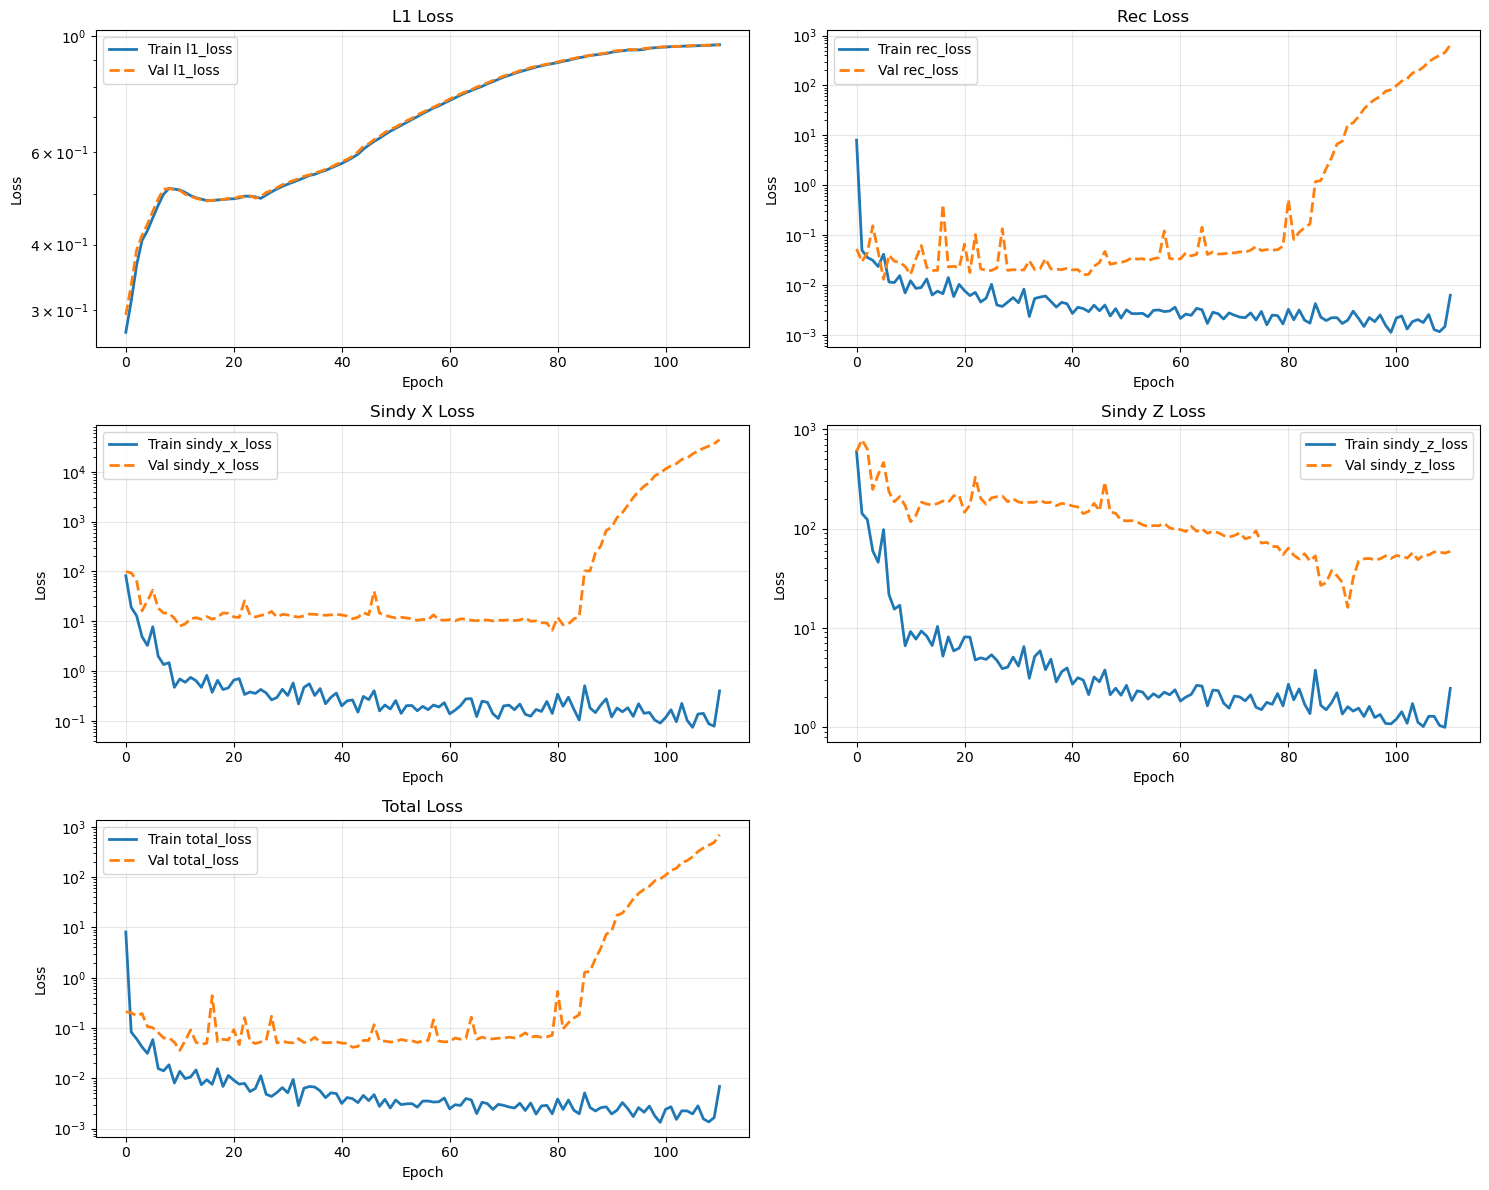

In [20]:
# Run this in a new cell
plot_training_losses(trainer, log_scale=True)

In [ ]:
# 3. Output Results
print("\n" + "="*30)
print("FINAL DISCOVERED EQUATIONS")
print("="*30)

# Get coefficients
coeffs = trainer.model.sindy.coefficients.numpy()

# Define feature names based on poly_order
feature_names = ["1"]
latent_dim = params['latent_dim']

# Linear terms
for i in range(latent_dim):
    feature_names.append(f"z{i}")

# Quadratic terms (if poly_order >= 2)
if params['poly_order'] >= 2:
    for i in range(latent_dim):
        for j in range(i, latent_dim):
            feature_names.append(f"z{i}z{j}")
            
# Sine terms (if include_sine is True)
if params['include_sine']:
    for i in range(latent_dim):
        feature_names.append(f"sin(z{i})")

# Print in readable format
print(f"{'Feature':<10} | {'d(z0)/dt':<10} | {'d(z1)/dt':<10} | {'d(z2)/dt' if latent_dim>2 else ''}")
print("-" * 45)
for i, name in enumerate(feature_names):
    row = coeffs[i]
    # Only print if row has non-zero values (approx)
    if np.any(np.abs(row) > 1e-4):
        val0 = f"{row[0]:.4f}"
        val1 = f"{row[1]:.4f}"
        val2 = f"{row[2]:.4f}" if latent_dim > 2 else ""
        print(f"{name:<10} | {val0:<10} | {val1:<10} | {val2}")


# Let's do the optimisation with the strategies to increase the performance, but straight optimisation does not seem to work

In [44]:
n_epochs_SVD = 1
n_epochs_Lock = 300
n_epochs = 1000
params = default_params.copy()

params['coefficient_initialization'] = 'true'
params['sindy_pert'] = 0.02

# 2. Train Model
print("\nStarting Training...")
trainer = TrainModel(S, params)

print(f"--- Running Experiment: {CASE_NAME.upper()} ---")
print(f"System: {params['model']}")
print(f"Coefficients: {params['system_coefficients']}")

# 1. Generate Data
print("\nGenerating Synthetic Data...")
S = SynthData(model=params['model'],
            args=params['system_coefficients'],
            noise=params['noise'],
            input_dim=params['input_dim'],
            normalization=params['normalization'])

# Run simulation to create the Hankel matrix (time-delay embeddings)
S.run_sim(params['n_ics'], params['tend'], params['dt'])


Starting Training...
--- Running Experiment: LORENZ ---
System: predator_prey
Coefficients: None

Generating Synthetic Data...
generating solutions..


100%|██████████| 5/5 [00:00<00:00, 37.42it/s]


In [38]:
trainer.model.sindy.coefficients.numpy(), trainer.data.sindy_coefficients

(array([[-0.00469879,  0.00941511],
        [ 0.9952791 ,  0.00167106],
        [-0.00196687, -1.5007603 ],
        [-0.00323865, -0.0065901 ],
        [-0.10099278,  0.06649144],
        [ 0.00961697,  0.00585717]], dtype=float32),
 array([[ 0.   ,  0.   ],
        [ 1.   ,  0.   ],
        [ 0.   , -1.5  ],
        [ 0.   ,  0.   ],
        [-0.1  ,  0.075],
        [ 0.   ,  0.   ]], dtype=float32))

In [39]:
from sklearn.decomposition import TruncatedSVD
import tensorflow as tf

def pretrain_with_svd(trainer, S, epochs=200):
    """
    Pre-trains the Autoencoder to mimic a linear SVD transformation.
    This initializes the coordinate system to a 'sensible' shape (unfolded attractor)
    before SINDy tries to discover the equations.
    """
    print(f"\n=== STARTING SVD PRE-TRAINING ({epochs} epochs) ===")
    
    # 1. Prepare Data
    # S.x is (input_dim, n_samples) -> Transpose for Keras (n_samples, input_dim)
    X_train = S.x.T.astype('float32') 
    
    # 2. Compute SVD Target
    print("Computing SVD of the input data...")
    svd = TruncatedSVD(n_components=trainer.params['latent_dim'])
    # This creates the target latent variables (the "Shadow" attractor)
    X_svd = svd.fit_transform(X_train).astype('float32')
    
    # 3. Pre-train ENCODER (Input -> SVD)
    # We compile ONLY the encoder. The SINDy layer and Decoder are untouched.
    print(f"--> Training Encoder to map Inputs to SVD Coordinates...")
    trainer.model.encoder.compile(optimizer='adam', loss='mse')
    trainer.model.encoder.fit(
        x=X_train, 
        y=X_svd, 
        epochs=epochs,       # <--- Explicitly uses YOUR number
        batch_size=1024,     # Large batch size for speed
        shuffle=True,
        verbose=0            # Keep it quiet (0) or show progress (1)
    )
    print("    Encoder Done.")

    # 4. Pre-train DECODER (SVD -> Input)
    # We compile ONLY the decoder.
    print(f"--> Training Decoder to map SVD Coordinates back to Inputs...")
    trainer.model.decoder.compile(optimizer='adam', loss='mse')
    trainer.model.decoder.fit(
        x=X_svd, 
        y=X_train, 
        epochs=epochs,       # <--- Explicitly uses YOUR number
        batch_size=1024, 
        shuffle=True,
        verbose=0
    )
    print("    Decoder Done.")
    print("=== SVD PRE-TRAINING COMPLETE ===\n")

In [45]:
import tensorflow as tf
import numpy as np
from aesindy.training import TrainModel, get_callbacks

# ---------------------------------------------------------
# PHASE 1: LOCK (Train Autoencoder on Fixed/True Physics)
# ---------------------------------------------------------
print("\n=== PHASE 1: LOCK (Learning Coordinate System) ===")

# 1. Configure for Phase 1
# We fix the coefficients to the "True" initialization so the AE 
# is forced to learn the correct "Butterfly" shape.
trainer.params['fix_coefs'] = True
trainer.params['coefficient_initialization'] = 'true' 
trainer.params['sindy_pert'] = 0.05  # Slight noise to test robustness
trainer.params['max_epochs'] = n_epochs_Lock   # Sufficient to learn the shape

# 2. Initialize and Train Model 1
# This builds the first TF graph where SINDy gradients are disabled.
trainer.model = trainer.get_model() 
optimizer = tf.keras.optimizers.Adam(learning_rate=trainer.params['learning_rate'])
trainer.model.compile(optimizer=optimizer, loss='mse')

# Standard training loop for Phase 1
trainer.fit() 

# ---------------------------------------------------------
# OPTIONAL: PERTURBATION (The "Discovery" Test)
# ---------------------------------------------------------
# Right now, the coefficients are perfect (or close). 
# To prove we can "discover" them, let's scramble them before Phase 2.
print("\n--- Scrambling Coefficients ---")
current_weights = trainer.model.get_weights()
# The last element in get_weights() for this architecture is usually the SINDy coeffs.
# But to be safe, we access the layer directly.
coeffs = trainer.model.sindy.coefficients.numpy()
scrambled_coeffs = coeffs + np.random.normal(0, 2.0, size=coeffs.shape) # Add heavy noise
trainer.model.sindy.coefficients.assign(scrambled_coeffs)
print("Coefficients are now scrambled (Bad Physics).")

# ---------------------------------------------------------
# PHASE 2: UNLOCK (Train Everything)
# ---------------------------------------------------------
print("\n=== PHASE 2: UNLOCK (Refining Physics & Shape) ===")

# 1. Update Parameters for Phase 2
trainer.params['fix_coefs'] = False   # Allow SINDy to learn
trainer.params['max_epochs'] = n_epochs   # Longer run for refinement

# 2. Create a FRESH Model Instance (The Author's Trick)
# We cannot reuse 'trainer.model' because its graph has frozen weights.
# We generate a new one which respects 'fix_coefs = False'.
model_phase2 = trainer.get_model()

# 3. Build the new model
# Keras models are empty until called on data.
_, test_data = trainer.get_data()
model_phase2.predict(test_data) 

# 4. Transfer Weights (The Critical Step)
# We copy the learned Encoder/Decoder from Phase 1 to Phase 2.
# Note: We take weights from the *modified* Phase 1 model (with scrambled coeffs)
print("Transferring weights to new trainable model...")
model_phase2.set_weights(trainer.model.get_weights())

# 5. Swap the model in the trainer
trainer.model = model_phase2

# 6. Compile and Train
# This builds a NEW graph where SINDy gradients are enabled.
optimizer = tf.keras.optimizers.Adam(learning_rate=trainer.params['learning_rate'])
trainer.model.compile(optimizer=optimizer, loss='mse')

trainer.fit()

print("\n=== TRAINING COMPLETE ===")


=== PHASE 1: LOCK (Learning Coordinate System) ===
results_202511291642_predator_prey_rando
{'data_path': 'results/', 'case': 'rando', 'model': 'predator_prey', 'tend': 20, 'dt': 0.001, 'tau': None, 'system_coefficients': None, 'normalization': None, 'latent_dim': 2, 'noise': 0.0, 'interpolate': False, 'interp_dt': 0.01, 'interp_kind': 'cubic', 'interp_coefs': [21, 3], 'n_ics': 5, 'train_ratio': 0.8, 'input_dim': 128, 'poly_order': 2, 'include_sine': False, 'exact_features': False, 'svd_dim': None, 'scale': False, 'ode_net': False, 'ode_net_widths': [1.5, 3], 'coefficient_threshold': 1e-06, 'threshold_frequency': 100, 'coefficient_initialization': 'true', 'fixed_coefficient_mask': False, 'fix_coefs': True, 'trainable_auto': True, 'sindy_pert': 0.05, 'loss_weight_rec': 1.0, 'loss_weight_sindy_z': 0.0001, 'loss_weight_sindy_x': 0.001, 'loss_weight_sindy_regularization': 1e-05, 'loss_weight_integral': 0.0, 'loss_weight_x0': 0.0, 'loss_weight_layer_l2': 0.0, 'loss_weight_layer_l1': 0.0, '

/Users/benpro/miniforge3/envs/deep_delay_mac/lib/python3.10/site-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'sindy__autoencoder_17', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


621/621 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
Transferring weights to new trainable model...
results_202511291642_predator_prey_rando
{'data_path': 'results/', 'case': 'rando', 'model': 'predator_prey', 'tend': 20, 'dt': 0.001, 'tau': None, 'system_coefficients': None, 'normalization': None, 'latent_dim': 2, 'noise': 0.0, 'interpolate': False, 'interp_dt': 0.01, 'interp_kind': 'cubic', 'interp_coefs': [21, 3], 'n_ics': 5, 'train_ratio': 0.8, 'input_dim': 128, 'poly_order': 2, 'include_sine': False, 'exact_features': False, 'svd_dim': None, 'scale': False, 'ode_net': False, 'ode_net_widths': [1.5, 3], 'coefficient_threshold': 1e-06, 'threshold_frequency': 100, 'coefficient_initialization': 'true', 'fixed_coefficient_mask': False, 'fix_coefs': False, 'trainable_auto': True, 'sindy_pert': 0.05, 'loss_weight_rec': 1.0, 'loss_weight_sindy_z': 0.0001, 'loss_weight_sindy_x': 0.001, 'loss_weight_sindy_regularization': 1e-05, 'loss_weight_integral': 0.0, 'loss_weight_x0': 0.0, 'loss_weight_layer_l

In [46]:
# 3. Output Results
print("\n" + "="*30)
print("FINAL DISCOVERED EQUATIONS")
print("="*30)

# Get coefficients
coeffs = trainer.model.sindy.coefficients.numpy()

# Define feature names based on poly_order
feature_names = ["1"]
latent_dim = params['latent_dim']

# Linear terms
for i in range(latent_dim):
    feature_names.append(f"z{i}")

# Quadratic terms (if poly_order >= 2)
if params['poly_order'] >= 2:
    for i in range(latent_dim):
        for j in range(i, latent_dim):
            feature_names.append(f"z{i}z{j}")
            
# Sine terms (if include_sine is True)
if params['include_sine']:
    for i in range(latent_dim):
        feature_names.append(f"sin(z{i})")

# Print in readable format
print(f"{'Feature':<10} | {'d(z0)/dt':<10} | {'d(z1)/dt':<10} | {'d(z2)/dt' if latent_dim>2 else ''}")
print("-" * 45)
for i, name in enumerate(feature_names):
    row = coeffs[i]
    # Only print if row has non-zero values (approx)
    if np.any(np.abs(row) > 1e-4):
        val0 = f"{row[0]:.4f}"
        val1 = f"{row[1]:.4f}"
        val2 = f"{row[2]:.4f}" if latent_dim > 2 else ""
        print(f"{name:<10} | {val0:<10} | {val1:<10} | {val2}")



FINAL DISCOVERED EQUATIONS
Feature    | d(z0)/dt   | d(z1)/dt   | 
---------------------------------------------
1          | 3.8990     | -1.4991    | 
z0         | 1.7670     | -1.8334    | 
z1         | 2.0413     | -2.3397    | 
z0z0       | 0.0842     | 0.0773     | 
z0z1       | 0.1612     | 0.1470     | 
z1z1       | 0.0075     | 0.0058     | 


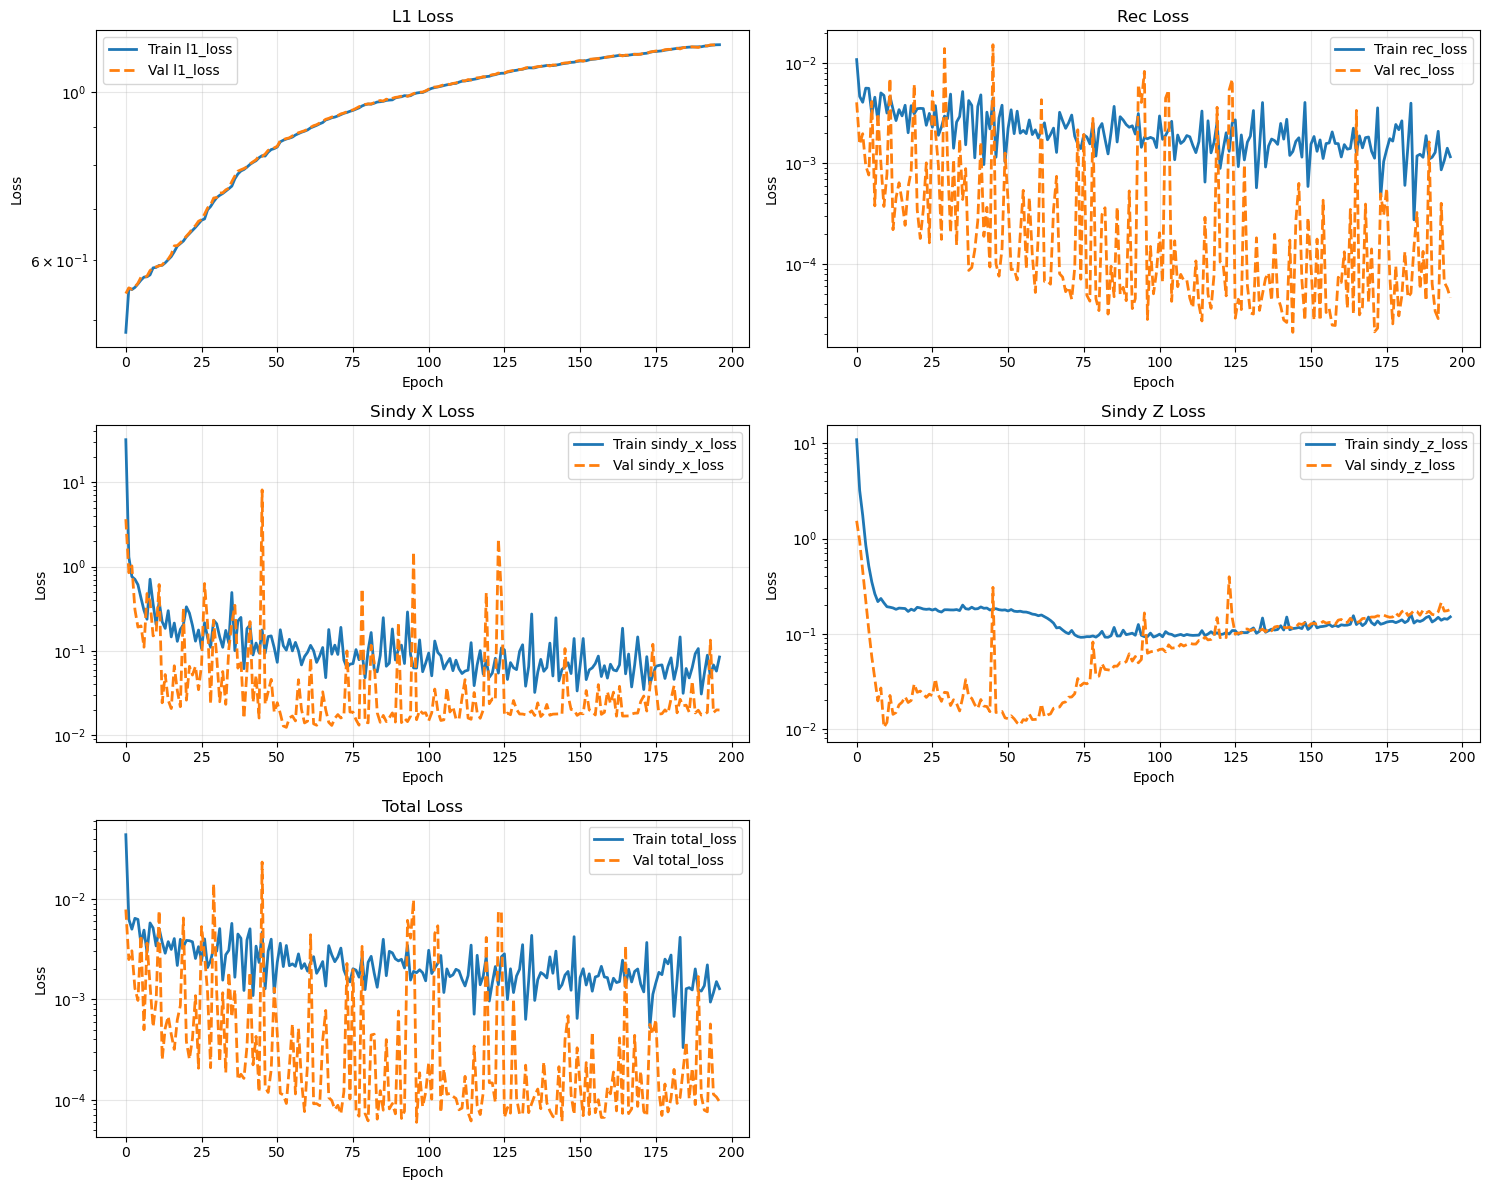

In [47]:
# Run this in a new cell
plot_training_losses(trainer, log_scale=True)

# Test with Warfarin

Generating Warfarin TMDD Data...
generating solutions..


100%|██████████| 1/1 [00:00<00:00, 151.01it/s]


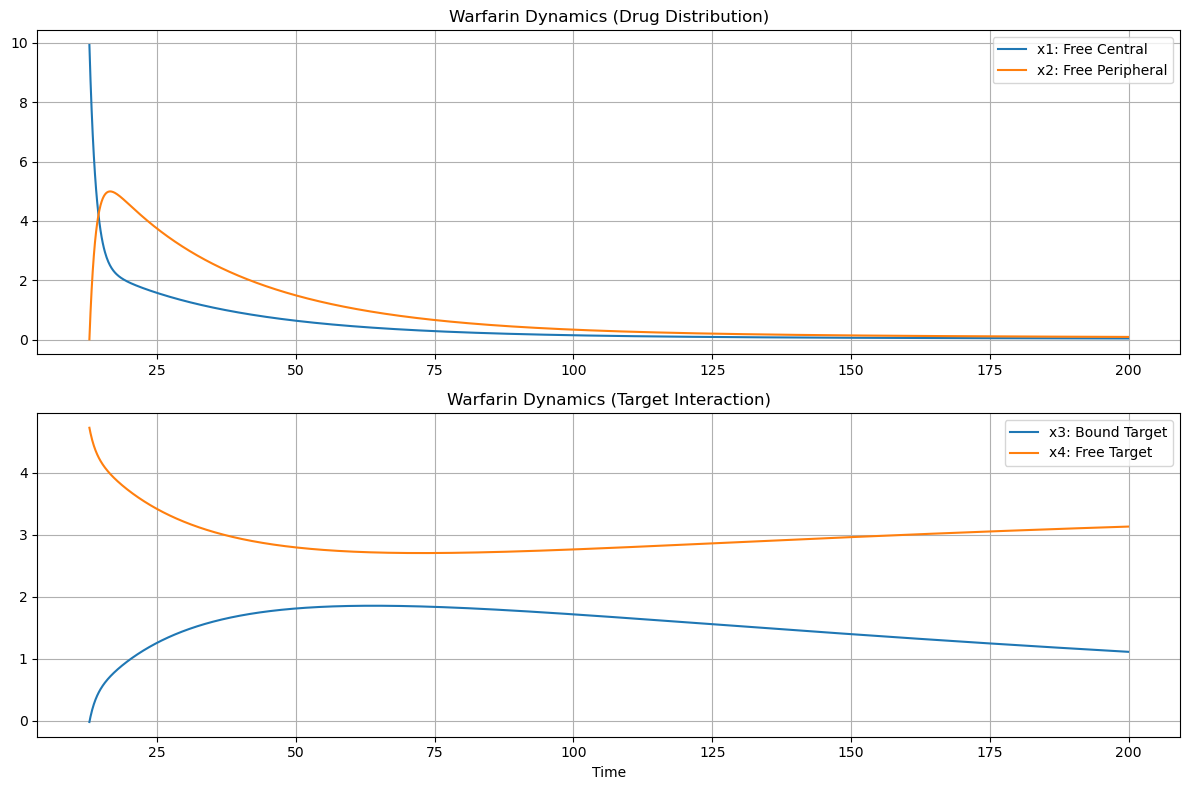


--- Ground Truth SINDy Coefficients ---
These are the equations the model will try to discover:
[[ 0.     0.     0.     0.002]
 [-0.6    0.5    0.     0.   ]
 [ 0.25  -0.25   0.     0.   ]
 [ 0.005  0.    -0.006  0.005]
 [ 0.     0.     0.    -0.001]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [-0.01   0.     0.01  -0.01 ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]
 [ 0.     0.     0.     0.   ]]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from aesindy.solvers import SynthData

# 1. Define Warfarin Parameters
params = {}
params['model'] = 'warfarin'
# Args: [CL, V1, Q, V2, kon, koff, kdeg, ksyn]
params['system_coefficients'] = [0.1, 1.0, 0.5, 2.0, 0.01, 0.005, 0.001, 0.002]
params['normalization'] = [1.0, 1.0, 1.0, 1.0] # No scaling for visualization
params['dt'] = 0.1
params['input_dim'] = 128
params['n_ics'] = 1   # Just 1 trajectory to visualize
params['tend'] = 200  # 200 seconds duration
params['noise'] = 0.0

# 2. Generate Data
print("Generating Warfarin TMDD Data...")
S = SynthData(model=params['model'], 
              args=params['system_coefficients'],
              noise=params['noise'], 
              input_dim=params['input_dim'],
              normalization=params['normalization'])

# This runs the odeint solver using the 'warfarin' block we just added
S.run_sim(params['n_ics'], params['tend'], params['dt'])

# 3. Plot Trajectories
start_idx = params['input_dim']
t = S.t[start_idx:]  # Slice time to match the data
x = S.z              # The data is already shortened

plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(t, x[:, 0], label='x1: Free Central')
plt.plot(t, x[:, 1], label='x2: Free Peripheral')
plt.title('Warfarin Dynamics (Drug Distribution)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(t, x[:, 2], label='x3: Bound Target')
plt.plot(t, x[:, 3], label='x4: Free Target')
plt.title('Warfarin Dynamics (Target Interaction)')
plt.xlabel('Time')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print("\n--- Ground Truth SINDy Coefficients ---")
print("These are the equations the model will try to discover:")
print(S.sindy_coefficients)

Generating Synthetic Data for warfarin...
generating solutions..


100%|██████████| 20/20 [00:00<00:00, 191.86it/s]


Initializing Model...

 PARAMETER INITIALIZATION CHECK
TRUE Coefficients (First 5 rows):
[[ 0.     0.     0.     0.002]
 [-0.6    0.5    0.     0.   ]
 [ 0.25  -0.25   0.     0.   ]
 [ 0.005  0.    -0.006  0.005]
 [ 0.     0.     0.    -0.001]]

INITIAL Coefficients (True + 0.25 perturbation):
[[ 0.12307683  0.0761025   0.12173139  0.08865259]
 [-0.4884676   0.45830125  0.02777386 -0.06857153]
 [ 0.24159102 -0.24070321  0.04127036  0.00461514]
 [ 0.11992003 -0.00101177 -0.03604124 -0.03069304]
 [-0.07008915  0.00099133  0.0402103   0.0239397 ]]

Max perturbation applied: 0.12308

 STARTING TRAINING
results_202511301027_warfarin_rando
{'data_path': 'results_warfarin', 'case': 'rando', 'model': 'warfarin', 'tend': 200, 'dt': 0.1, 'tau': None, 'system_coefficients': [0.1, 1.0, 0.5, 2.0, 0.01, 0.005, 0.001, 0.002], 'normalization': [0.1, 0.1, 0.1, 0.1], 'latent_dim': 4, 'noise': 0.0, 'interpolate': False, 'interp_dt': 0.01, 'interp_kind': 'cubic', 'interp_coefs': [21, 3], 'n_ics': 20, 'tr

29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - l1_loss: 0.0807 - rec_loss: 0.3840 - sindy_x_loss: 0.0693 - sindy_z_loss: 0.4034 - total_loss: 0.4243--- Sindy Coefficients ---
<Variable path=sindy_3/sindy_coeffs, shape=(15, 4), dtype=float32, value=[[ 0.12075735  0.08180754  0.09980007  0.07075194]
 [-0.48891115  0.44379127  0.03753866 -0.0667984 ]
 [ 0.2319461  -0.2559357   0.05163447  0.00359125]
 [ 0.11241733 -0.01342887 -0.03814014 -0.01741401]
 [-0.06622724  0.01621103  0.02889608  0.01302362]
 [-0.04991714 -0.06991562 -0.00298969 -0.09695134]
 [-0.03148362  0.07998236 -0.1026938  -0.09185767]
 [-0.02448326 -0.06308602 -0.00222636 -0.0801117 ]
 [-0.14291297  0.08491182 -0.00860741 -0.04329884]
 [-0.09927494 -0.07339962  0.10435519 -0.02645859]
 [-0.05185043 -0.06989976 -0.03381718  0.08348051]
 [-0.00247743  0.03694947 -0.06677644 -0.09280554]
 [-0.06078484  0.1290191  -0.03810997  0.1049557 ]
 [ 0.00946429  0.06905341  0.07816438  0.06857806]
 [-0.10788632  0.03873456  0.00883653  0.03

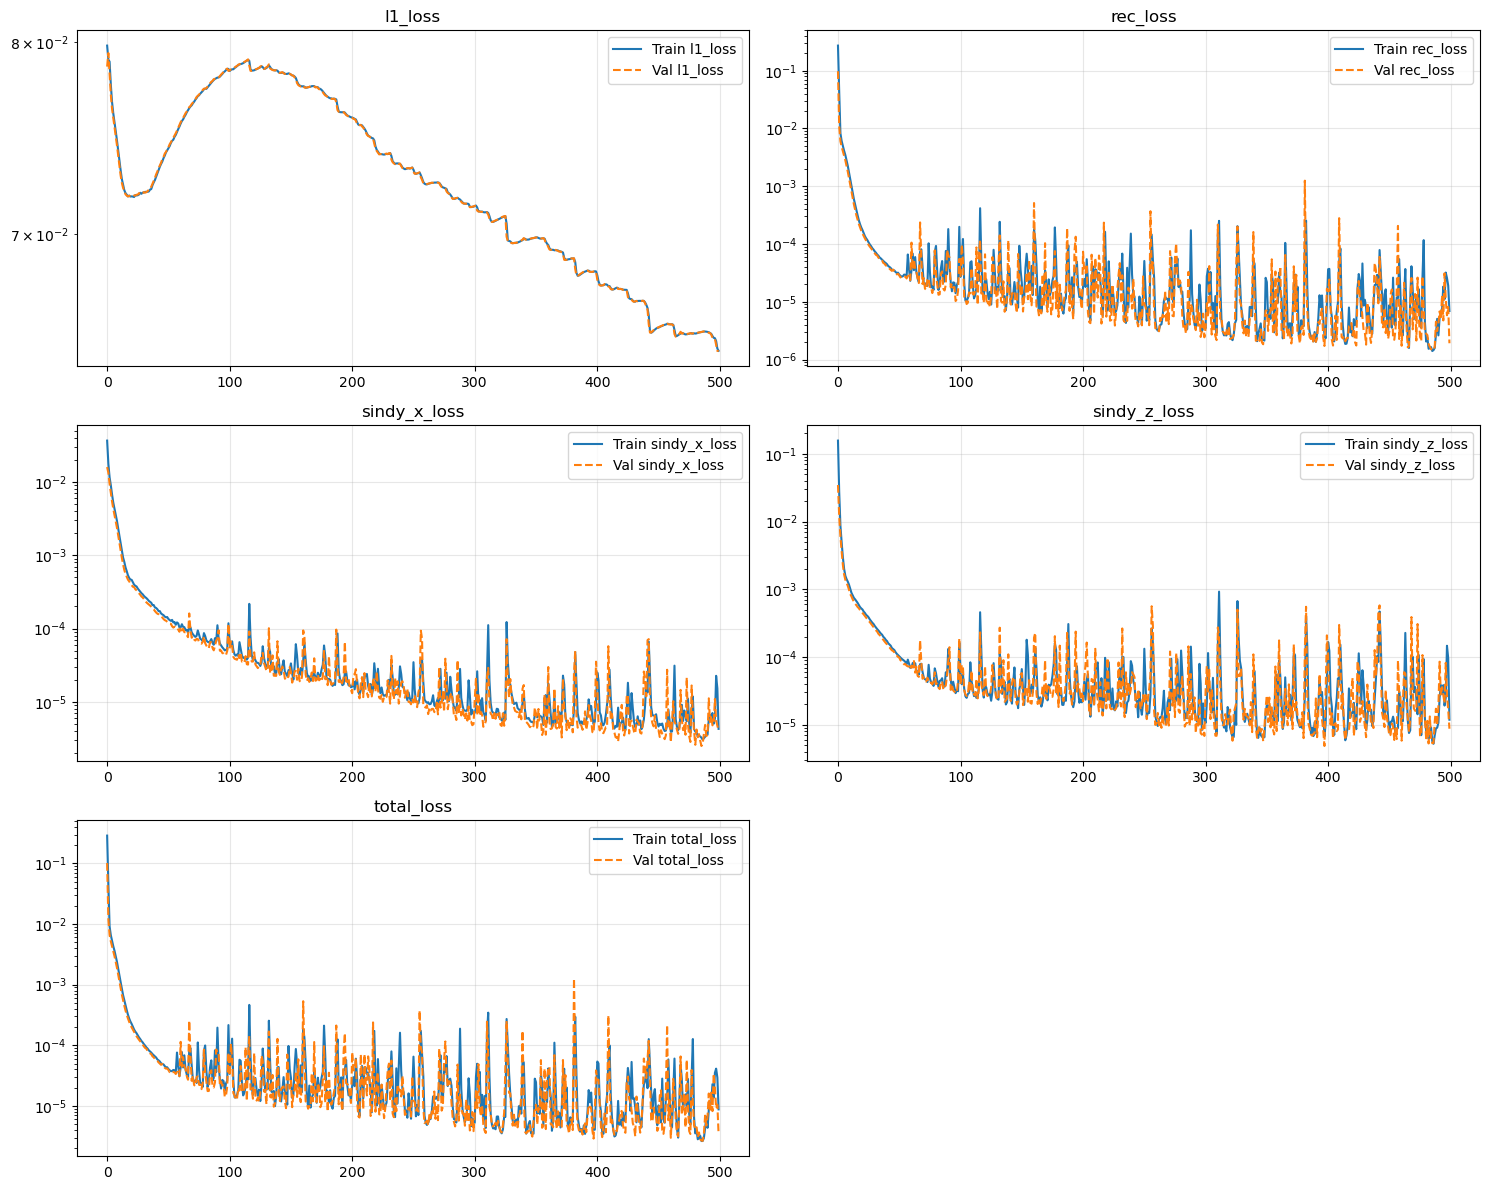


Final Coefficients:
 [[ 1.6969420e-02 -1.7849198e-02  2.5382677e-02 -5.6945500e-03]
 [-3.4391710e-01  3.1098881e-01 -6.6702284e-02 -4.3368604e-02]
 [ 2.2784975e-01 -2.4113216e-01  1.0495779e-02  2.8549917e-02]
 [ 8.7476008e-02  3.1536903e-02 -2.9503739e-01  4.0261097e-02]
 [-1.4116952e-01  1.1657036e-01  9.6315213e-02 -7.9177774e-02]
 [-3.4089439e-02 -5.1789917e-03 -1.4069224e-02 -1.7254712e-02]
 [ 3.6712181e-02  1.3781418e-01 -1.3553204e-01 -1.6998062e-02]
 [-1.0361433e-03 -4.0370710e-02  5.2208200e-02 -3.6376495e-02]
 [-9.5282413e-02  6.5011159e-02 -2.3526970e-02 -5.7539390e-04]
 [-1.2628503e-02 -7.5716905e-02  6.5835007e-02  1.5220870e-02]
 [-5.2071311e-02 -1.4564545e-02  4.3056097e-02  4.6229627e-02]
 [-2.2458337e-02  2.4240406e-02 -3.8859725e-02 -4.7614399e-02]
 [-1.3334253e-02 -6.5783872e-03  3.2606333e-02  7.6566583e-05]
 [-9.0604633e-02 -2.3297500e-02  7.6285794e-02 -2.1291166e-03]
 [-1.5532154e-01  1.5838638e-02  1.2339583e-02 -4.8897680e-02]]


In [8]:
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

# Ensure we can import from the local folder
try:
    from aesindy.solvers import SynthData
    from aesindy.training import TrainModel
except ImportError:
    import sys
    sys.path.append(os.getcwd())
    from aesindy.solvers import SynthData
    from aesindy.training import TrainModel

from testcases.default_params import params as default_params

# ==========================================
# 1. CONFIGURE PARAMETERS
# ==========================================
params = {}
params = default_params.copy()


# --- System Config ---
params['model'] = 'warfarin'
params['latent_dim'] = 4          # 4 Variables: x1, x2, x3, x4
params['poly_order'] = 2          # Quadratic terms (like x1*x4) are required
params['include_sine'] = False    # No sine terms in Warfarin equations
# [CL, V1, Q, V2, kon, koff, kdeg, ksyn]
params['system_coefficients'] = [0.1, 1.0, 0.5, 2.0, 0.01, 0.005, 0.001, 0.002]
params['normalization'] = [0.1, 0.1, 0.1, 0.1] # Scale data to help NN convergence

# --- Data Generation ---
params['dt'] = 0.1                # Time step
params['input_dim'] = 128         # Time-delay window
params['n_ics'] = 20              # Number of trajectories
params['tend'] = 200              # Duration of each trajectory
params['noise'] = 0.0             # Add observation noise if desired

# --- Initialization (WARM START) ---
params['coefficient_initialization'] = 'true' # Start from Ground Truth
params['sindy_pert'] = 0.25     # Add 5% noise (Perturbation)
params['fix_coefs'] = False       # Allow SINDy to learn/refine
params['fixed_coefficient_mask'] = False

# --- Training Hyperparameters ---
params['max_epochs'] = 500       # Give it time to converge
params['batch_size'] = 1024       # Larger batch for stability
params['learning_rate'] = 1e-3
params['print_progress'] = True
params['print_frequency'] = 100
params['data_path'] = 'results_warfarin'
params['save_checkpoints'] = False

# --- Neural Network Architecture ---
params['widths_ratios'] = [0.5, 0.25]
params['activation'] = 'elu'
params['use_bias'] = True

# --- Loss Weights (Tuned for Discovery) ---
params['loss_weight_rec'] = 1.0
params['loss_weight_sindy_z'] = 0.1        # Strong pressure to match equations
params['loss_weight_sindy_x'] = 1e-4
params['loss_weight_sindy_regularization'] = 1e-5
params['loss_weight_integral'] = 0.0
params['loss_weight_x0'] = 0.0
params['loss_weight_layer_l2'] = 0.0
params['loss_weight_layer_l1'] = 0.0

# Unused params required by code
params['svd_dim'] = None
params['scale'] = False
params['ode_net'] = False
params['trainable_auto'] = True
params['sparse_weighting'] = None
params['ode_net_widths'] = []
params['exact_features'] = False 

# ==========================================
# 2. EXECUTION
# ==========================================
if __name__ == "__main__":
    
    # --- Generate Data ---
    print(f"Generating Synthetic Data for {params['model']}...")
    S = SynthData(model=params['model'],
                  args=params['system_coefficients'],
                  noise=params['noise'],
                  input_dim=params['input_dim'],
                  normalization=params['normalization'])
    S.run_sim(params['n_ics'], params['tend'], params['dt'])
    
    # Cast to float32 for Mac/TensorFlow compatibility
    S.x = S.x.astype('float32')
    S.dx = S.dx.astype('float32')

    # --- Initialize Trainer ---
    print("\nInitializing Model...")
    trainer = TrainModel(S, params)
    
    # --- VERIFICATION: Check Coefficients ---
    print("\n" + "="*40)
    print(" PARAMETER INITIALIZATION CHECK")
    print("="*40)
    
    # 1. Ground Truth (What we want to find)
    true_coeffs = S.sindy_coefficients
    print(f"TRUE Coefficients (First 5 rows):\n{true_coeffs[:5, :]}")
    
    # 2. Initial Guess (What the model starts with)
    # We expect this to be True + Noise
    init_coeffs = trainer.model.sindy.coefficients.numpy()
    print(f"\nINITIAL Coefficients (True + {params['sindy_pert']} perturbation):\n{init_coeffs[:5, :]}")
    
    # 3. Difference
    diff = np.abs(true_coeffs - init_coeffs)
    print(f"\nMax perturbation applied: {np.max(diff):.5f}")
    
    # --- Train ---
    print("\n" + "="*40)
    print(" STARTING TRAINING")
    print("="*40)
    trainer.fit()
    
    # --- Plotting Function ---
    def plot_losses(history):
        metrics = [k for k in history.keys() if not k.startswith('val_')]
        n_cols = 2
        n_rows = (len(metrics) + 1) // n_cols
        
        plt.figure(figsize=(15, 4 * n_rows))
        for i, metric in enumerate(metrics):
            plt.subplot(n_rows, n_cols, i+1)
            plt.plot(history[metric], label=f'Train {metric}')
            if f'val_{metric}' in history:
                plt.plot(history[f'val_{metric}'], '--', label=f'Val {metric}')
            plt.title(metric)
            plt.yscale('log')
            plt.legend()
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    plot_losses(trainer.history.history)
    
    print("\nFinal Coefficients:\n", trainer.model.sindy.coefficients.numpy())

In [10]:
import numpy as np

def print_sindy_equations(model, latent_dim, feature_names=None, threshold=1e-3):
    """
    Parses the SINDy coefficient matrix and prints readable equations.
    
    Args:
        model: The trained model object (containing model.sindy.coefficients)
        latent_dim: Number of variables (e.g., 4 for Warfarin)
        feature_names: Optional list of variable names ['x1', 'x2', ...]
        threshold: Coefficients smaller than this will be treated as 0.
    """
    coeffs = model.sindy.coefficients.numpy()
    
    # 1. Create Feature Names if not provided
    if feature_names is None:
        feature_names = [f"x{i+1}" for i in range(latent_dim)]
        
    # 2. Generate Library Terms List (Polynomial Order 2)
    # Order: 1, x1, x2, ..., x1^2, x1x2, ...
    terms = ["1"] # Bias
    # Linear terms
    for i in range(latent_dim):
        terms.append(feature_names[i])
    # Quadratic terms
    for i in range(latent_dim):
        for j in range(i, latent_dim):
            terms.append(f"{feature_names[i]}{feature_names[j]}")

    print("\n--- DISCOVERED EQUATIONS ---")
    print(f"(Terms smaller than {threshold} are hidden)\n")
    
    # 3. Build Equations
    for col in range(latent_dim):
        equation_parts = []
        target_var = f"d({feature_names[col]})/dt"
        
        for row in range(len(terms)):
            val = coeffs[row, col]
            
            # Only keep significant terms (Manual Thresholding)
            if abs(val) > threshold:
                sign = "+" if val > 0 else "-"
                val_abs = abs(val)
                term = terms[row]
                
                if term == "1":
                    equation_parts.append(f"{sign} {val_abs:.4f}")
                else:
                    equation_parts.append(f"{sign} {val_abs:.4f}*{term}")
        
        # Join parts to make the string
        eq_str = " ".join(equation_parts)
        # Clean up leading "+"
        if eq_str.startswith("+ "):
            eq_str = eq_str[2:]
            
        print(f"{target_var} = {eq_str}")

# --- RUN IT ---
# feature_names=['C_central', 'C_periph', 'C_bound', 'C_target'] # Optional: Use real names
print_sindy_equations(trainer.model, latent_dim=4, threshold=0.01)


--- DISCOVERED EQUATIONS ---
(Terms smaller than 0.01 are hidden)

d(x1)/dt = 0.0170 - 0.3439*x1 + 0.2278*x2 + 0.0875*x3 - 0.1412*x4 - 0.0341*x1x1 + 0.0367*x1x2 - 0.0953*x1x4 - 0.0126*x2x2 - 0.0521*x2x3 - 0.0225*x2x4 - 0.0133*x3x3 - 0.0906*x3x4 - 0.1553*x4x4
d(x2)/dt = - 0.0178 + 0.3110*x1 - 0.2411*x2 + 0.0315*x3 + 0.1166*x4 + 0.1378*x1x2 - 0.0404*x1x3 + 0.0650*x1x4 - 0.0757*x2x2 - 0.0146*x2x3 + 0.0242*x2x4 - 0.0233*x3x4 + 0.0158*x4x4
d(x3)/dt = 0.0254 - 0.0667*x1 + 0.0105*x2 - 0.2950*x3 + 0.0963*x4 - 0.0141*x1x1 - 0.1355*x1x2 + 0.0522*x1x3 - 0.0235*x1x4 + 0.0658*x2x2 + 0.0431*x2x3 - 0.0389*x2x4 + 0.0326*x3x3 + 0.0763*x3x4 + 0.0123*x4x4
d(x4)/dt = - 0.0434*x1 + 0.0285*x2 + 0.0403*x3 - 0.0792*x4 - 0.0173*x1x1 - 0.0170*x1x2 - 0.0364*x1x3 + 0.0152*x2x2 + 0.0462*x2x3 - 0.0476*x2x4 - 0.0489*x4x4


In [ ]:
plot_training_losses(trainer, log_scale=True)